# This file contains legacy code. 
Some parts need to be generalized and incorporated into `aladdin predict`

In [2]:
import sys
sys.path.append('..')
import tensorflow as tf


from utilities.model_evaluation import recover_model
from utilities import database_reader
from utilities import msa_converter
from utilities import model_evaluation
import utilities.onehot_tuple_encoder as ote



In [3]:
# On some versions of CuDNN the default LSTM implementation
# raises a warning. The following code deals with these cases
# See [here](https://github.com/tensorflow/tensorflow/issues/36508)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Hyperparam

In [4]:
split_specifications  = {
              'train': {'name': 'train', 'wanted_models': [0, 1], 'interweave_models': [.67, .33], 'repeat_models': [False, False]},
              'val': {'name': 'val', 'wanted_models': [0, 1], 'interweave_models': True, 'repeat_models': [False, False]},
              'test': {'name': 'test', 'wanted_models': [0, 1], 'interweave_models': True, 'repeat_models': [False, False]},
          }
batch_size = 30
basenames = ['fly', 'vertebrate', 'yeast']
wanted_splits = ['test']
input_dir = "../../aladdin_input/"



trial_ids = {
    'fly_rnn':   '2020.08.19--12.06.53',
    'vert_rnn':  '2020.08.18--17.34.39',
    'yeast_rnn': '2020.08.18--19.07.48',
    'all_rnn':   '2020.08.20--16.06.20',
    'all_small': '2020.08.21--09.11.59',
}

#trial_id = "2020.08.13--14.25.48"
saved_weights_dir = "../../aladdin_experiments/saved_weights"
log_dir = "../../aladdin_experiments/logs"
clades = ["../../aladdin_input/fly.nwk", "../../aladdin_input/vertebrate.nwk", "../../aladdin_input/yeast.nwk", ]
fasta_filelists = ['fasta_fly_test.txt']
use_codons = True
entry_length = 3

In [5]:
alphabet_size = 4 ** entry_length

In [6]:
# import the list of fasta file paths
fasta_paths = []
for fl in fasta_filelists:
    with open(fl) as f:
        fasta_paths = fasta_paths + f.read().splitlines()
    
print(len(fasta_paths))

3000


In [32]:
from Bio import SeqIO
import numpy as np

def concat_sequences(clade_ids, sequence_lengths, sequences):
    concat_sequences = tf.cast(
        tf.boolean_mask(sequences, tf.sequence_mask(sequence_lengths)), 
        dtype = tf.float64)
    
    X = (concat_sequences, tf.repeat(clade_ids, sequence_lengths, axis=0), sequence_lengths)
    
    return (X, None)

def parse_fasta_file(fasta_path, clades, margin_width=0):
    
    species = [msa_converter.leaf_order(c,use_alternatives=True) for c in clades] if clades != None else []
    
    entries = [rec for rec in SeqIO.parse(fasta_path, "fasta")]
    # parse the species names
    spec_in_file = [e.id.split('|')[0] for e in entries]

    # compare them with the given references
    ref_ids = [[(r,i) for r in range(len(species))  for i in range(len(species[r])) if s in species[r][i] ] for s in spec_in_file]

    # check if these are contained in exactly one reference clade
    n_refs = [len(x) for x in ref_ids]

    if 0 == min(n_refs) or max(n_refs) > 1:
        return None

    ref_ids = [x[0] for x in ref_ids]

    if len(set(r for (r,i) in ref_ids)) > 1:
        return None

    # the first entry of the fasta file has the header informations
    header_fields = entries[0].id.split("|")

    # read the sequences and trim them if wanted
    sequences = [str(rec.seq).lower() for rec in entries]
    sequences = sequences[margin_width:-margin_width] if margin_width > 0 else sequences

    msa = msa_converter.MSA(
        model = None,
        chromosome_id = None, 
        start_index = None,
        end_index = None,
        is_on_plus_strand = True if len(header_fields) < 5 or header_fields[4] != 'revcomp' else False,
        frame = int(header_fields[2][-1]),
        spec_ids = ref_ids,
        offsets = [],
        sequences = sequences
    )
    # Use the correct onehot encded sequences
    coded_sequences = msa.coded_codon_aligned_sequences if use_codons else msa.coded_sequences
    
    # Infer the length of the sequences
    sequence_length = len(coded_sequences[1])  
    
    if sequence_length == 0:
        return None

    # cardinality of the alphabet that has been onehot-encoded
    s = coded_sequences.shape[-1]
    
    # get the id of the used clade and leaves inside this clade
    clade_id = msa.spec_ids[0][0]
    num_species = max([len(specs) for specs in species])
    leaf_ids = [l for (c,l) in msa.spec_ids]
    
    
    # embed the coded sequences into a full MSA for the whole leaf-set of the given clade
    S = np.ones((num_species, sequence_length, s), dtype = np.int32)
    S[leaf_ids,...] = coded_sequences
    
    # make the shape conform with the usual way datasets are structured,
    # namely the columns of the MSA are the examples and should therefore
    # be the first axis
    S = np.transpose(S, (1,0,2))
    
    return clade_id, sequence_length, S

test_file = '../../aladdin_input/phylocsf/fly/test/controls/029/14542.fa'
clade_id, sl, S = parse_fasta_file(test_file, clades)
print(S.shape)
print(clade_id)
print(sl)

(68, 12, 64)
0
68


In [8]:
# import the fasta files and filter out empty codon aligned sequences
fasta_sequences = [model_evaluation.parse_fasta_file(f, clades) for f in fasta_paths]
fasta_sequences = [{'path': fasta_paths[i], 'sequence': seq[2], 'clade_id': seq[0], 'sequence_length': seq[1]} for i,seq in enumerate(fasta_sequences) if not seq is None] 

NameError: name 'msa_converter' is not defined

In [34]:
num_leaves = database_reader.num_leaves(clades)


# generate a dataset for these files
dataset = tf.data.Dataset.from_generator(lambda: [(seq['clade_id'], seq['sequence_length'], seq['sequence']) for seq in fasta_sequences], (tf.int32, tf.int64, tf.float64))

# batch and reshape sequences to match the input specification of tcmc
#ds = database_reader.padded_batch(ds, batch_size, num_leaves, alphabet_size)
padded_shapes = ([], [], [None, max(num_leaves), alphabet_size])
dataset = dataset.padded_batch(batch_size, 
                               padded_shapes = padded_shapes, 
                               padding_values = (
                                   tf.constant(0, tf.int32), 
                                   tf.constant(0, tf.int64), 
                                   tf.constant(1.0, tf.float64)
                              ))
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset = dataset.map(concat_sequences, num_parallel_calls = 4)


for X in dataset.take(1):
    print(X)

((<tf.Tensor: shape=(2782, 12, 64), dtype=float64, numpy=
array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       ...,

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 

# Load the model and compile it

In [35]:
models = {name: recover_model(trial_ids[name], clades, alphabet_size, log_dir, saved_weights_dir) for name in trial_ids}
#model.summary()


# model compilation
accuracy_metric = 'accuracy'
auroc_metric = tf.keras.metrics.AUC(num_thresholds = 1000, dtype = tf.float32, name='auroc')
num_thresholds = 1000.0
thresholds = [i * 1 / num_thresholds for i in range(int(num_thresholds)+1)]

fp = tf.keras.metrics.FalsePositives(thresholds=thresholds)
tp = tf.keras.metrics.TruePositives(thresholds=thresholds)
fn = tf.keras.metrics.FalseNegatives(thresholds=thresholds)
tn = tf.keras.metrics.TrueNegatives(thresholds=thresholds)



loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.0005)

for n in models:
    
    models[n].compile(optimizer = optimizer,
                  loss = loss,
                  metrics = [accuracy_metric, auroc_metric, fp, tp, fn, tn],
    )

# Load the wanted datasets

In [36]:
num_leaves = database_reader.num_leaves(clades)


# evaluate the split specifications
splits = {'train': None, 'val': None, 'test': None}

for k in split_specifications:
    if k in splits.keys():
        try:
            splits[k] = database_reader.DatasetSplitSpecification(**split_specifications[k])
        except TypeError as te:
            raise Exception(f"Invalid split specification for '{k}': {split_specifications[k]}") from te



wanted_splits = [split for split in splits.values() if split != None ]
datasets = {b: database_reader.get_datasets(input_dir, b, wanted_splits, num_leaves = num_leaves, alphabet_size = alphabet_size, seed = None, buffer_size = 1000) for b in basenames}


if any(['train' not in datasets[b] for b in basenames]):
    raise Exception("A 'train' split must be specified!")

for b in basenames:
    
    # prepare datasets for batching
    for split in datasets[b]:

        ds = datasets[b][split]

        # batch and reshape sequences to match the input specification of tcmc
        ds = database_reader.padded_batch(ds, batch_size, num_leaves, alphabet_size)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
        ds = ds.map(database_reader.concatenate_dataset_entries, num_parallel_calls = 4)

        datasets[b][split] = ds


# Sanity check

In [37]:
for b in basenames:
    for t in datasets[b]['train'].take(1):
        (sequences, clade_ids, sequence_lengths), y = t

        # extract the clade ids per batch
        padding = [[1,0]]
        ind = tf.pad(tf.cumsum(sequence_lengths), padding)[:-1]
        clade_ids = tf.gather(clade_ids, ind)

        # extract the model ids
        model_ids = tf.argmax(y, axis=1)
        
        print(f'Example batch from the "train" split of "{b}":')

        print(f'model_ids: {model_ids}')
        print(f'clade_ids: {clade_ids}')
        print(f'sequence_length: {sequence_lengths}')
        print(f'sequence_onehot.shape: {sequences.shape}')

        # to debug the sequence first transform it to its
        # original shape
        S = tf.transpose(sequences, perm = [1, 0, 2])

        # decode the sequence and print some columns
        dec = ote.OnehotTupleEncoder.decode_tfrecord_entry(S.numpy(), tuple_length = entry_length)
        print(f'first (up to) 8 alignment columns of decoded reshaped sequence: \n{dec[:,:8]}')

Example batch from the "train" split of "fly":
model_ids: [0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0]
clade_ids: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
sequence_length: [ 67  48  37  59  29  27  69 186  55  91 113   4  58 177 186  48  56  71
  36  19  41  46  41  28  59  46 336 154 164  91]
sequence_onehot.shape: (2442, 12, 64)
first (up to) 8 alignment columns of decoded reshaped sequence: 
[['---' '---' '---' '---' '---' '---' '---' '---']
 ['---' '---' '---' '---' '---' '---' '---' '---']
 ['---' '---' '---' '---' '---' '---' '---' '---']
 ['atg' 'cca' 'ttg' 'tgt' 'tcg' 'ggt' 'ggt' 'tat']
 ['atg' 'cca' 'ttg' 'tgt' 'tcg' 'ggt' 'ggt' 'tat']
 ['atg' 'cca' 'ttg' 'tgt' 'tcg' 'ggt' 'ggt' 'tat']
 ['---' '---' '---' '---' '---' '---' '---' '---']
 ['---' '---' '---' '---' '---' '---' '---' '---']
 ['---' '---' '---' '---' '---' '---' '---' '---']
 ['---' '---' '---' '---' '---' '---' '---' '---']
 ['---' '---' '---' '---' '---' '---' '---' '---']
 ['

# Evaluations

In [40]:
model = models['fly_rnn']
ds = datasets['fly']['test']

# for X in ds.take(1):
#     print(X)
# preds = []
# for X in dataset:
#     preds.append(model(X))
    


preds = model.predict(dataset)[:,1]
print(preds)

[0.5350167  0.77592427 0.14221251 ... 0.83799422 0.6827934  0.83212007]


In [7]:
loss = {}
acc = {}
auroc = {}
fp = {}
tp = {}
fn = {}
tn = {}

for n in models:
    
    loss[n] = {}
    acc[n] = {}
    auroc[n] = {}
    fp[n] = {}
    tp[n] = {}
    fn[n] = {}
    tn[n] = {}
    
    for b in basenames:
        
        ds = datasets[b]['test']
    
        loss[n][b], acc[n][b], auroc[n][b], fp[n][b], tp[n][b], fn[n][b], tn[n][b] = models[n].evaluate(ds)

30/30 [==============================] - 3s 91ms/step - loss: 0.6446 - accuracy: 0.6852 - auroc: 0.7591 - false_positives: 311.6054 - true_positives: 571.3946 - false_negatives: 311.6054 - true_negatives: 571.3946


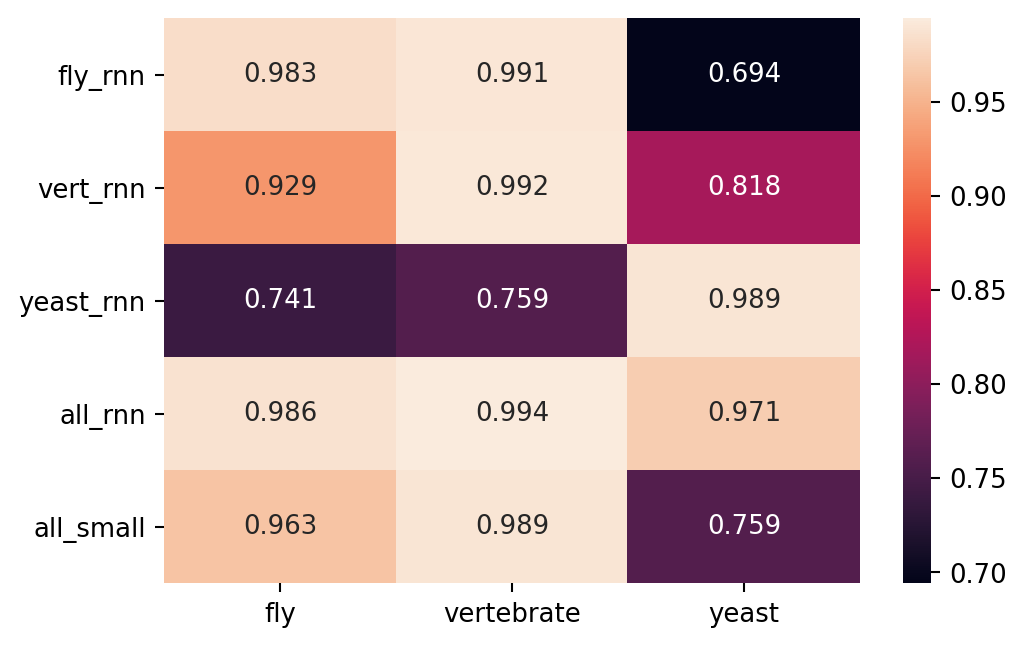

In [8]:
import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

index = list(models.keys())
columns = list(basenames)
df = DataFrame([[auroc[n][b] for b in basenames] for n in models], index=index, columns=columns)

f, ax = plt.subplots(figsize=(6, 4), dpi=187)
sns.heatmap(df, annot=True, fmt='.3f', ax=ax)
f.savefig('auroc_comparison.png')
#ax = sns.heatmap(A, annot=True, fmt=".2f", linewidths=.5, xticklabels=list(vs.amino_acids.keys()), yticklabels=list(vs.amino_acids.keys()), ax=ax)

In [8]:
print(fp)
print(tp)
print(fn)
print(tn)

[883. 883. 883. ...   0.   0.   0.]
[883. 883. 883. ...   0.   0.   0.]
[  0.   0.   0. ... 883. 883. 883.]
[  0.   0.   0. ... 883. 883. 883.]


In [11]:
y_true = []
y_score = []

for X,y in datasets['test']:
    y_score.append(model(X)[:,1])
    y_true.append(y[:,1])

y_score = tf.concat(y_score, axis=0)
y_true = tf.concat(y_true, axis=0)

print(y_score)
print(y_true)

tf.Tensor(
[0.20716092 0.90455857 0.06788913 0.95209344 0.85785193 0.62798054
 0.71009682 0.70103773 0.0219092  0.97181912 0.85460773 0.90623004
 0.33962745 0.94069992 0.15623758 0.30009704 0.0046501  0.97245008
 0.93125278 0.53176907 0.78377973 0.94352439 0.96857162 0.20434028
 0.0165227  0.26942429 0.09094013 0.65668822 0.95122832 0.17910554
 0.31104392 0.55559371 0.15609874 0.97256549 0.60697247 0.91843985
 0.97454668 0.82625263 0.00461407 0.11956927 0.89038534 0.17362827
 0.03408385 0.21267924 0.34442117 0.01548791 0.09494153 0.00692139
 0.92152272 0.02951988 0.26920697 0.7818828  0.29927657 0.34661506
 0.7156243  0.95041795 0.90225515 0.01169966 0.72598451 0.05460733
 0.02910913 0.95272728 0.02815845 0.24417067 0.95621368 0.01667673
 0.01235244 0.01008547 0.92397763 0.85125606 0.86994726 0.48690625
 0.43094444 0.29226694 0.85172697 0.48570743 0.00528642 0.09773295
 0.88628367 0.21541769 0.14994407 0.10095332 0.16470389 0.29591617
 0.01869208 0.00935195 0.00707882 0.03842537 0.0295

In [12]:
def roc_curve(y_true, y_score, thresholds):
    
    num_thresholds = len(thresholds)
    y_score = tf.expand_dims(y_score, axis=1)
    y_score = tf.tile(y_score, [1, num_thresholds])
    
    t = tf.cast(y_true, tf.bool)
    t = tf.expand_dims(t, axis=1)
    t = tf.tile(t, [1, num_thresholds])
    f = tf.math.logical_not(t)
    
    p = y_score >= thresholds
    n = tf.math.logical_not(p)
    
    
    fp = tf.math.logical_and(f, p)
    fn = tf.math.logical_and(t, n)
    tp = tf.math.logical_and(t, p)
    tn = tf.math.logical_and(f, n)
    
    fp = tf.math.count_nonzero(fp, axis=0, dtype=tf.float64)
    fn = tf.math.count_nonzero(fn, axis=0, dtype=tf.float64)
    tp = tf.math.count_nonzero(tp, axis=0, dtype=tf.float64)
    tn = tf.math.count_nonzero(tn, axis=0, dtype=tf.float64)
    
    fpr = fp / (fp+tn)
    tpr = tp / (tp+fn)
    print(fp[15:20])
    print(fn[15:20])
    print(tp[15:20])
    print(tn[15:20])
    
    return fpr, tpr
    

num_thresholds = 1000.0
thresholds = [i * 1 / num_thresholds for i in range(int(num_thresholds)+1)]

fpr, tpr = roc_curve(y_true, y_score, thresholds)

blub = y_score > thresholds[15]
print(tf.reduce_sum(tf.cast(blub, tf.float32)))
print(fp[15:20])

tf.Tensor([492. 485. 481. 477. 474.], shape=(5,), dtype=float64)
tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float64)
tf.Tensor([327. 327. 327. 327. 326.], shape=(5,), dtype=float64)
tf.Tensor([64. 71. 75. 79. 82.], shape=(5,), dtype=float64)
tf.Tensor(819.0, shape=(), dtype=float32)
[819. 812. 808. 804. 801.]


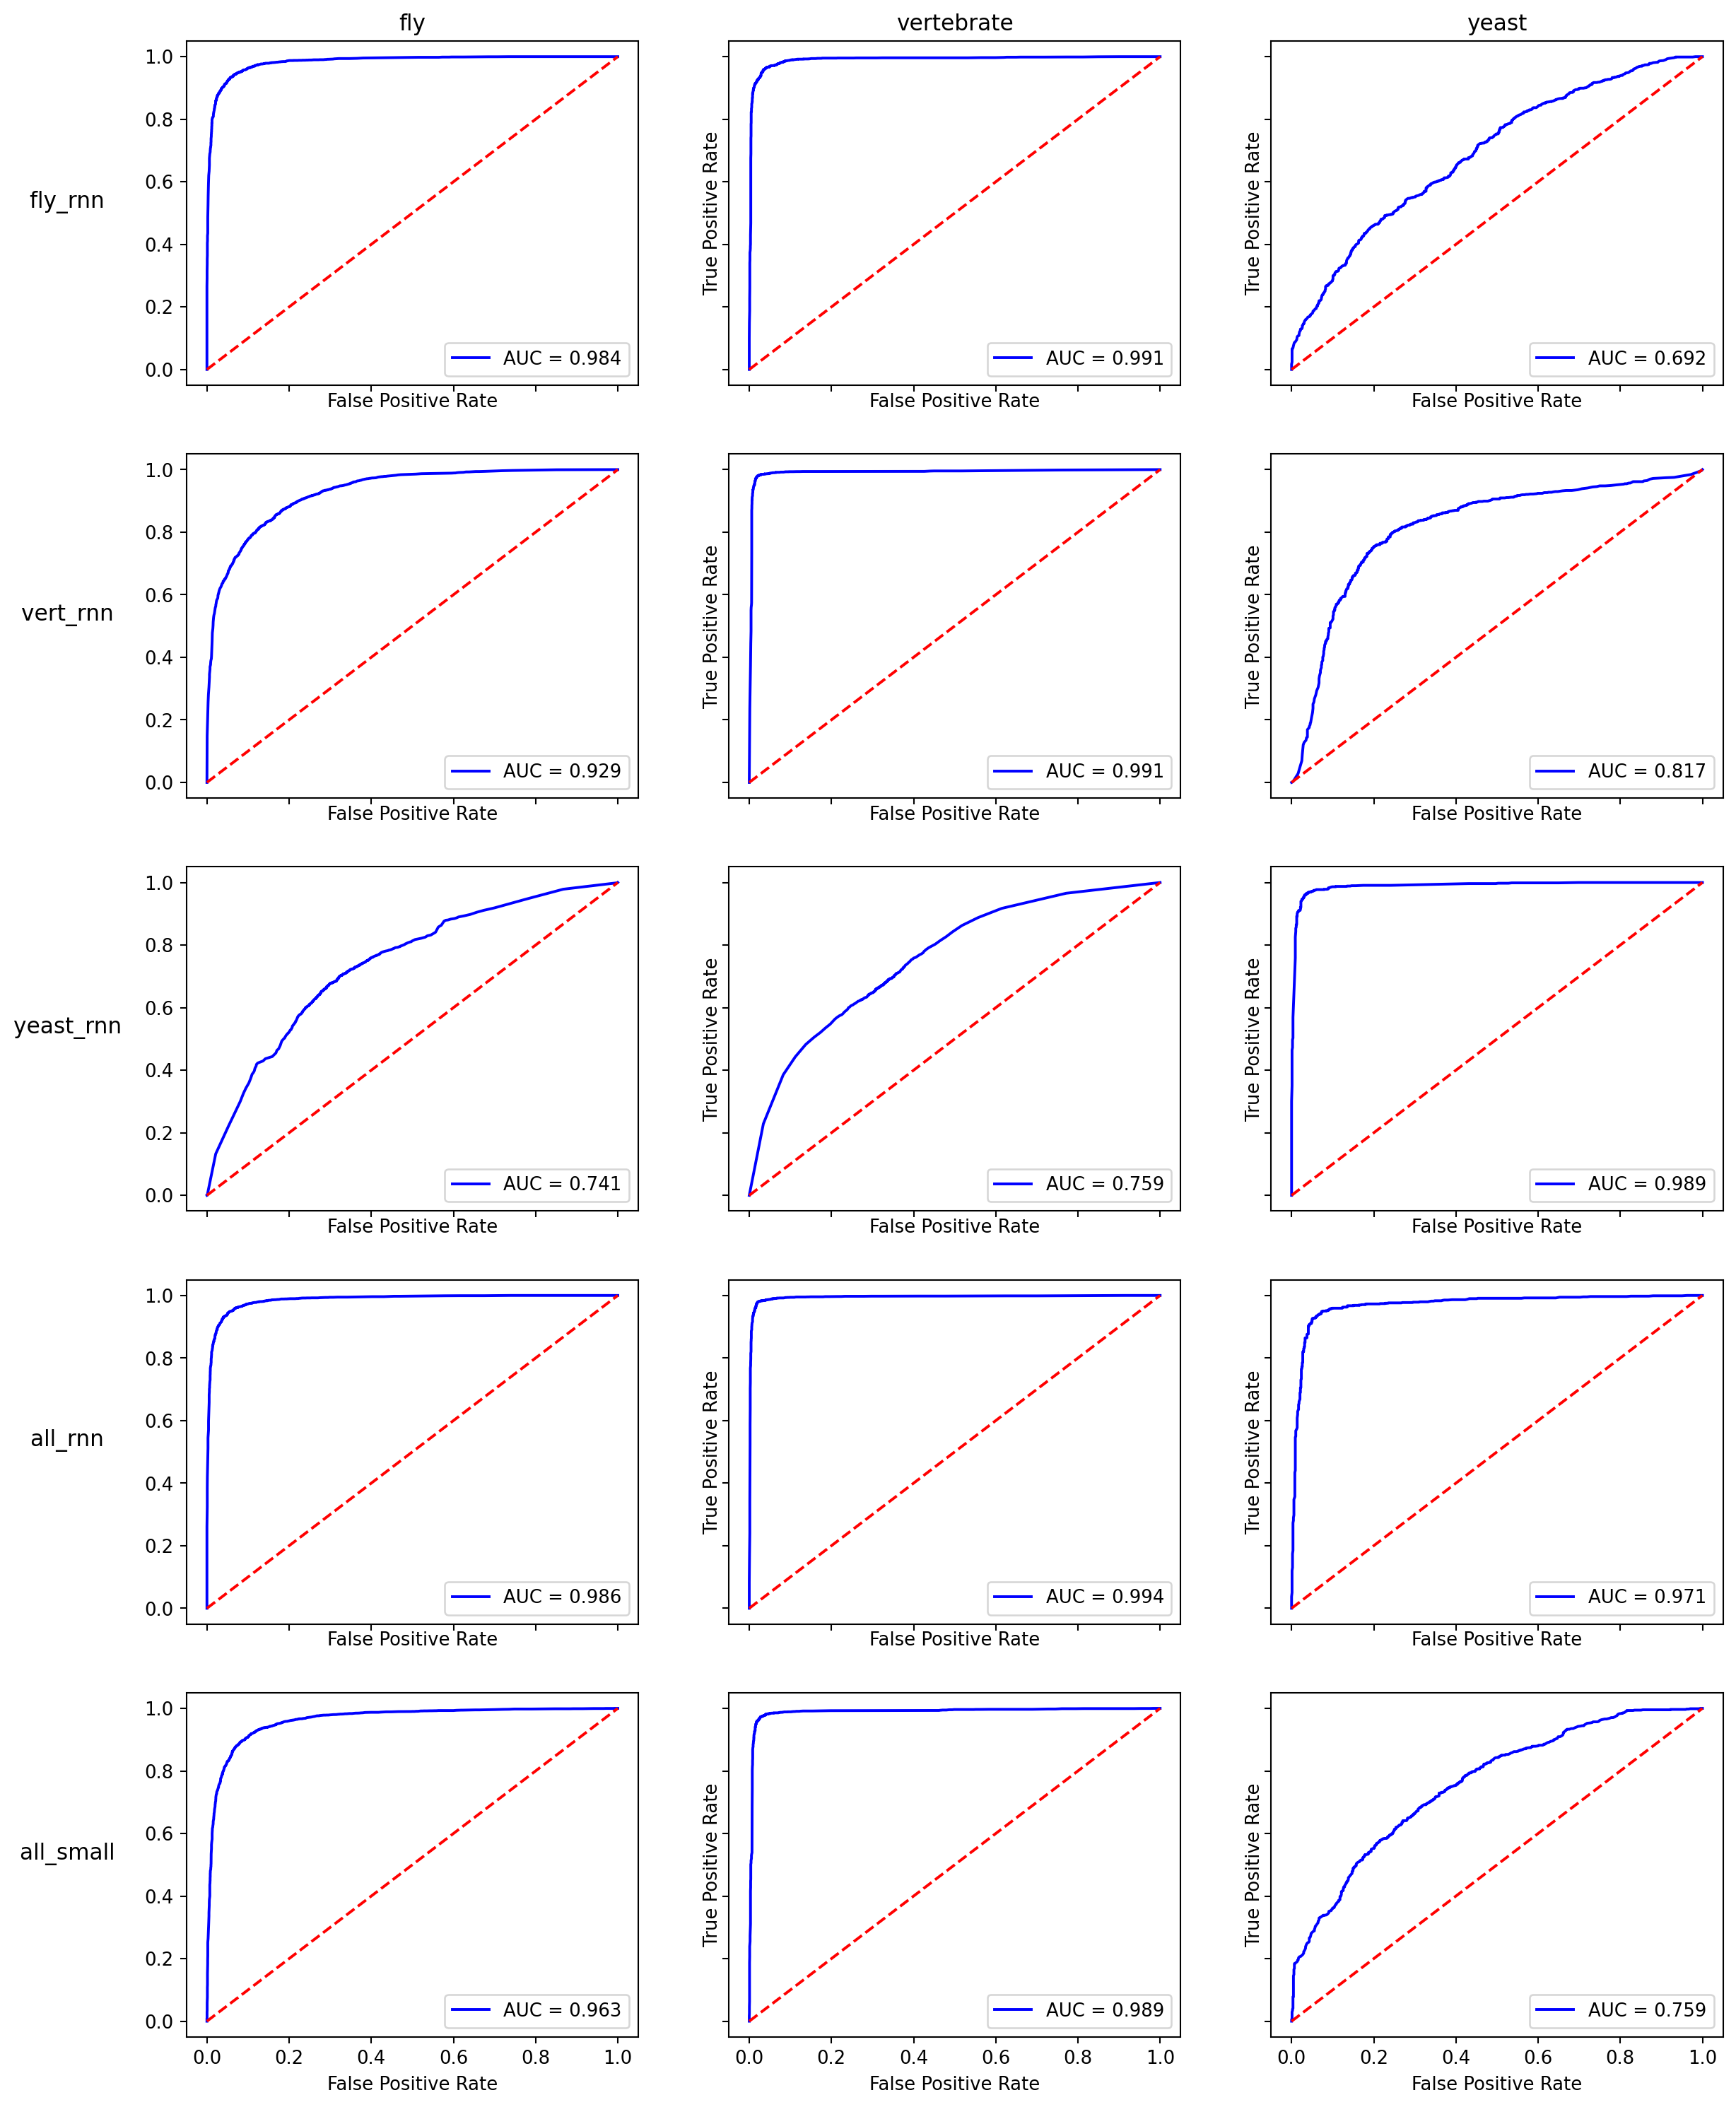

In [33]:
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(len(trial_ids), len(basenames), sharex='col', sharey='row', figsize=(15,20))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i,n in enumerate(trial_ids):
    for j, b in enumerate(basenames):
        
        fpr = fp[n][b] / (fp[n][b]+tn[n][b])
        tpr = tp[n][b] / (tp[n][b]+fn[n][b])
        roc_auc = metrics.auc(fpr, tpr)
        
        target_ax = ax[i][j]
        
        if i ==0:
            target_ax.set_title(f'{b}')
        target_ax.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
        target_ax.legend(loc = 'lower right')
        target_ax.plot([0, 1], [0, 1],'r--')
        #target_ax.xlim([0, 1])
        #target_ax.ylim([0, 1])
        target_ax.set_ylabel('True Positive Rate')
        
        if j == 0:
            target_ax.set_ylabel(f'{n}                    ', rotation=0, size='large')
        target_ax.set_xlabel('False Positive Rate')
        
fig.savefig('roc_curves.png')

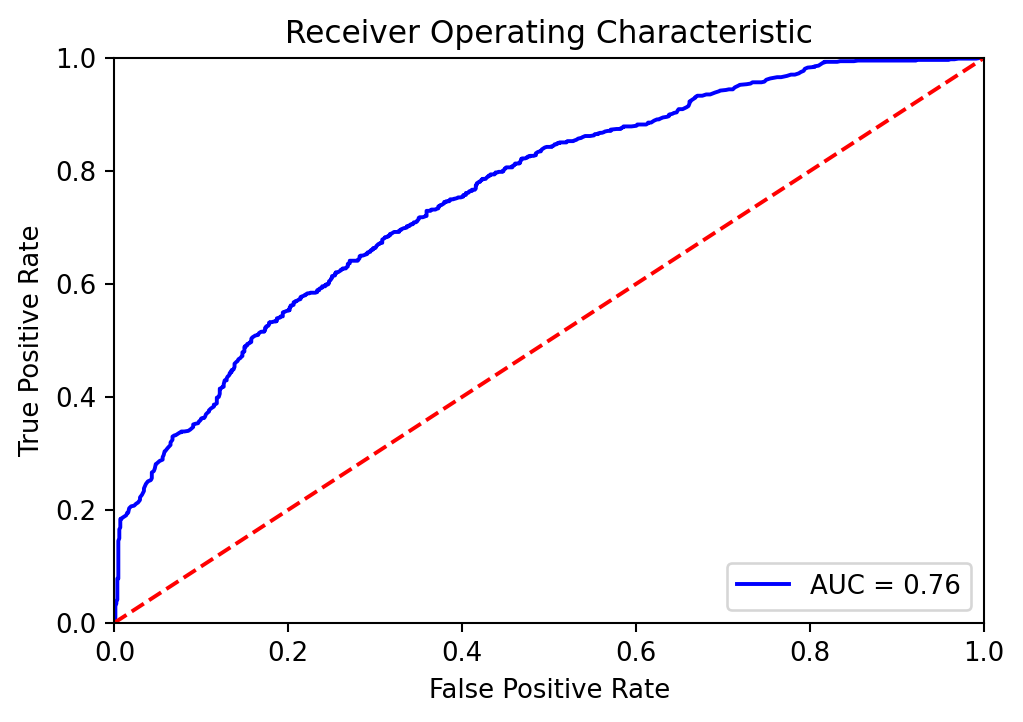

In [31]:
import sklearn.metrics as metrics
import numpy as np


# calculate the fpr and tpr for all thresholds of the classification
#fpr, tpr, threshold = metrics.roc_curve(y_true, y_score)
# fpr = fp / (fp+tn)
# tpr = tp / (tp+fn)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 187
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

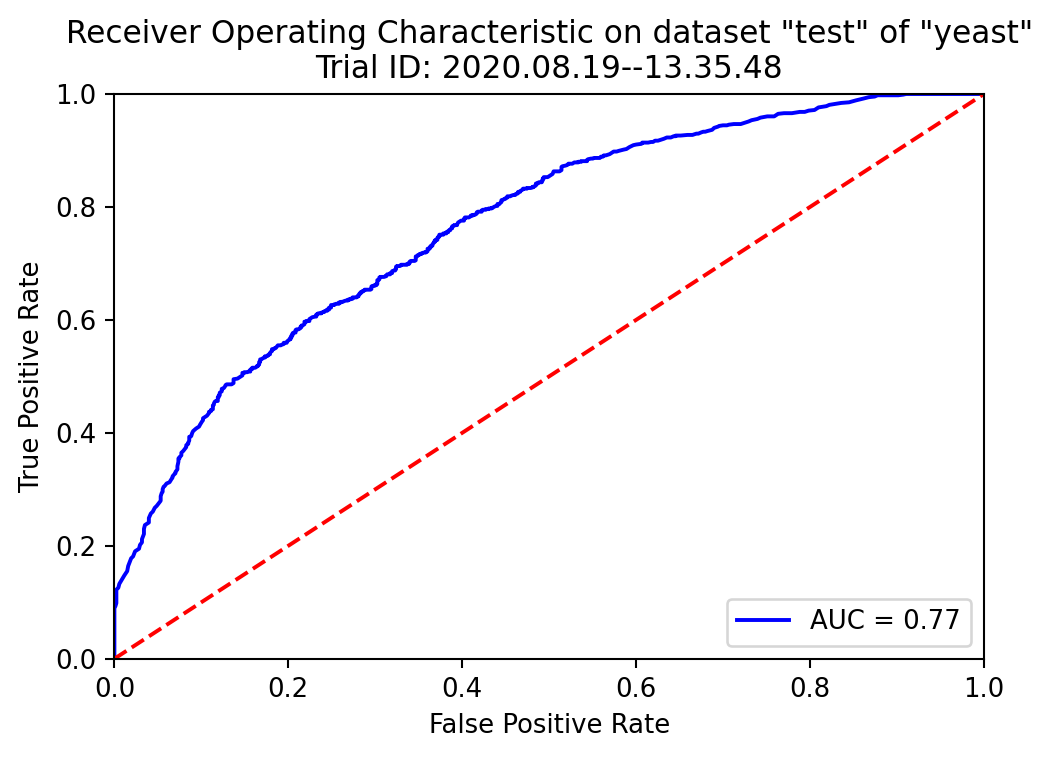

In [14]:
fpr = fp / (fp+tn)
tpr = tp / (tp+fn)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 187
plt.title(f'Receiver Operating Characteristic on dataset "test" of "{basename}"\nTrial ID: {trial_id}')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [8]:
import utilities.visualization as vs
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

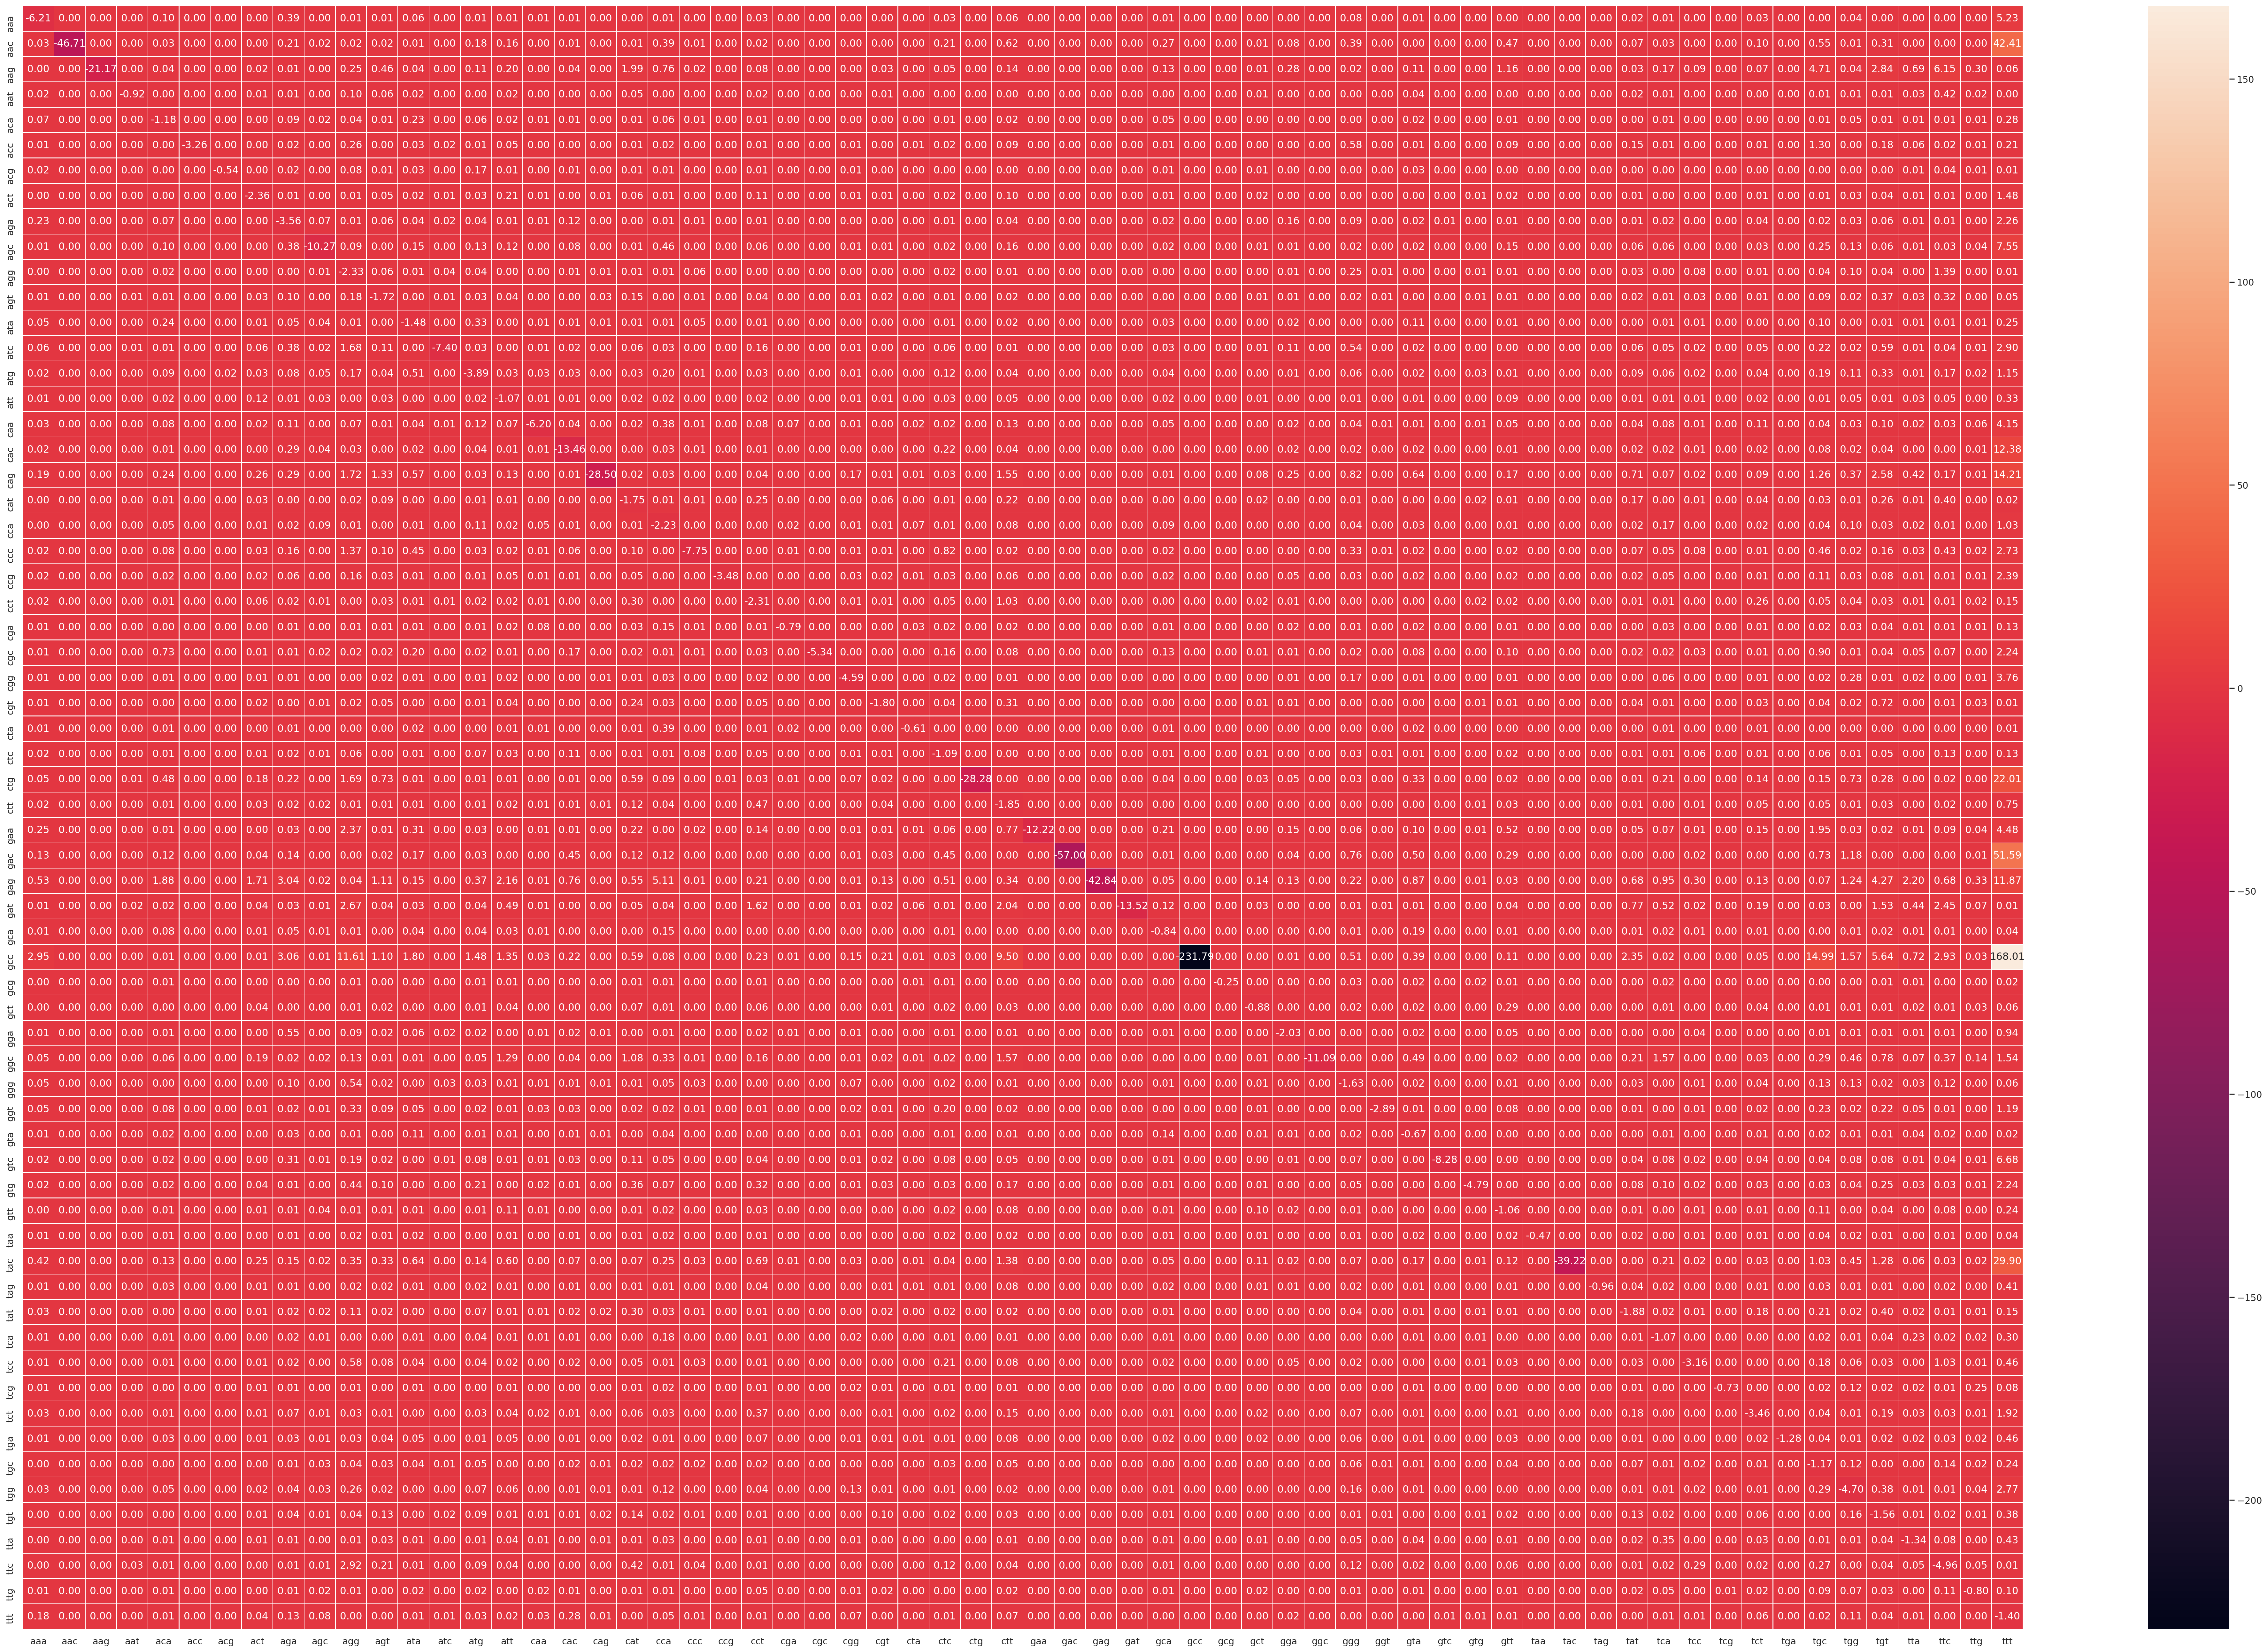

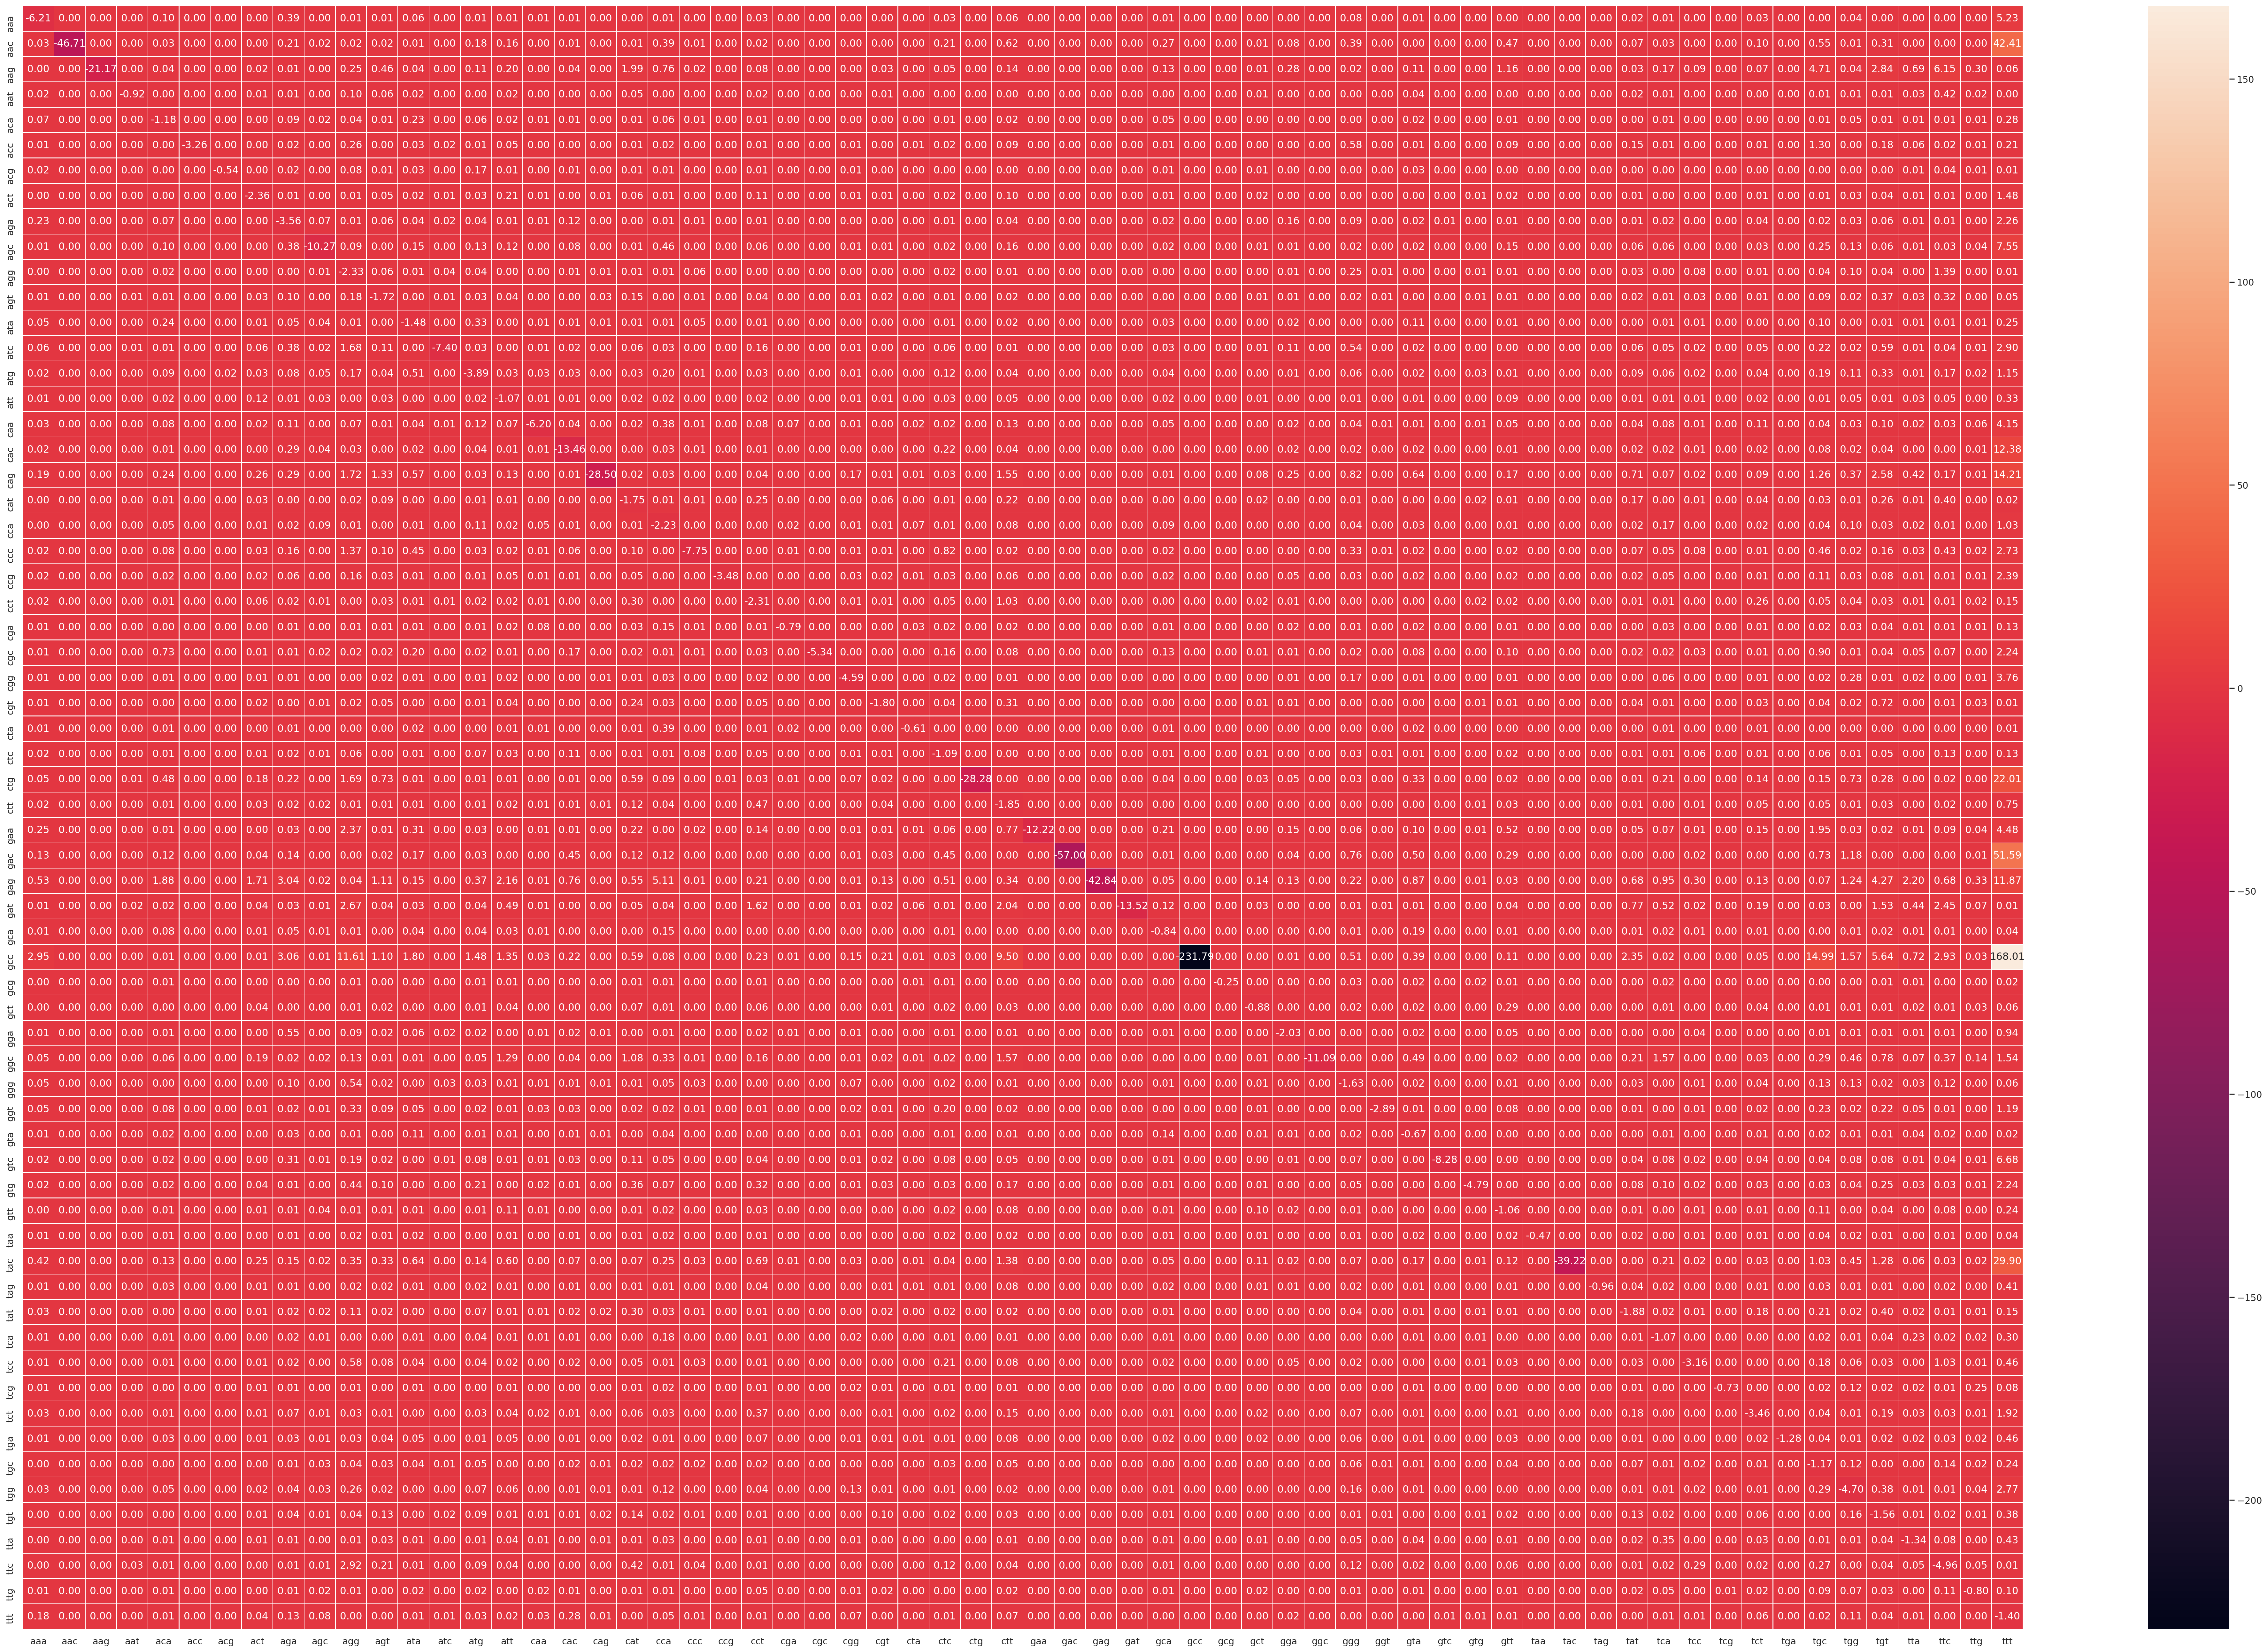

In [20]:
vs.plot_generator(tcmc, model_id=0)

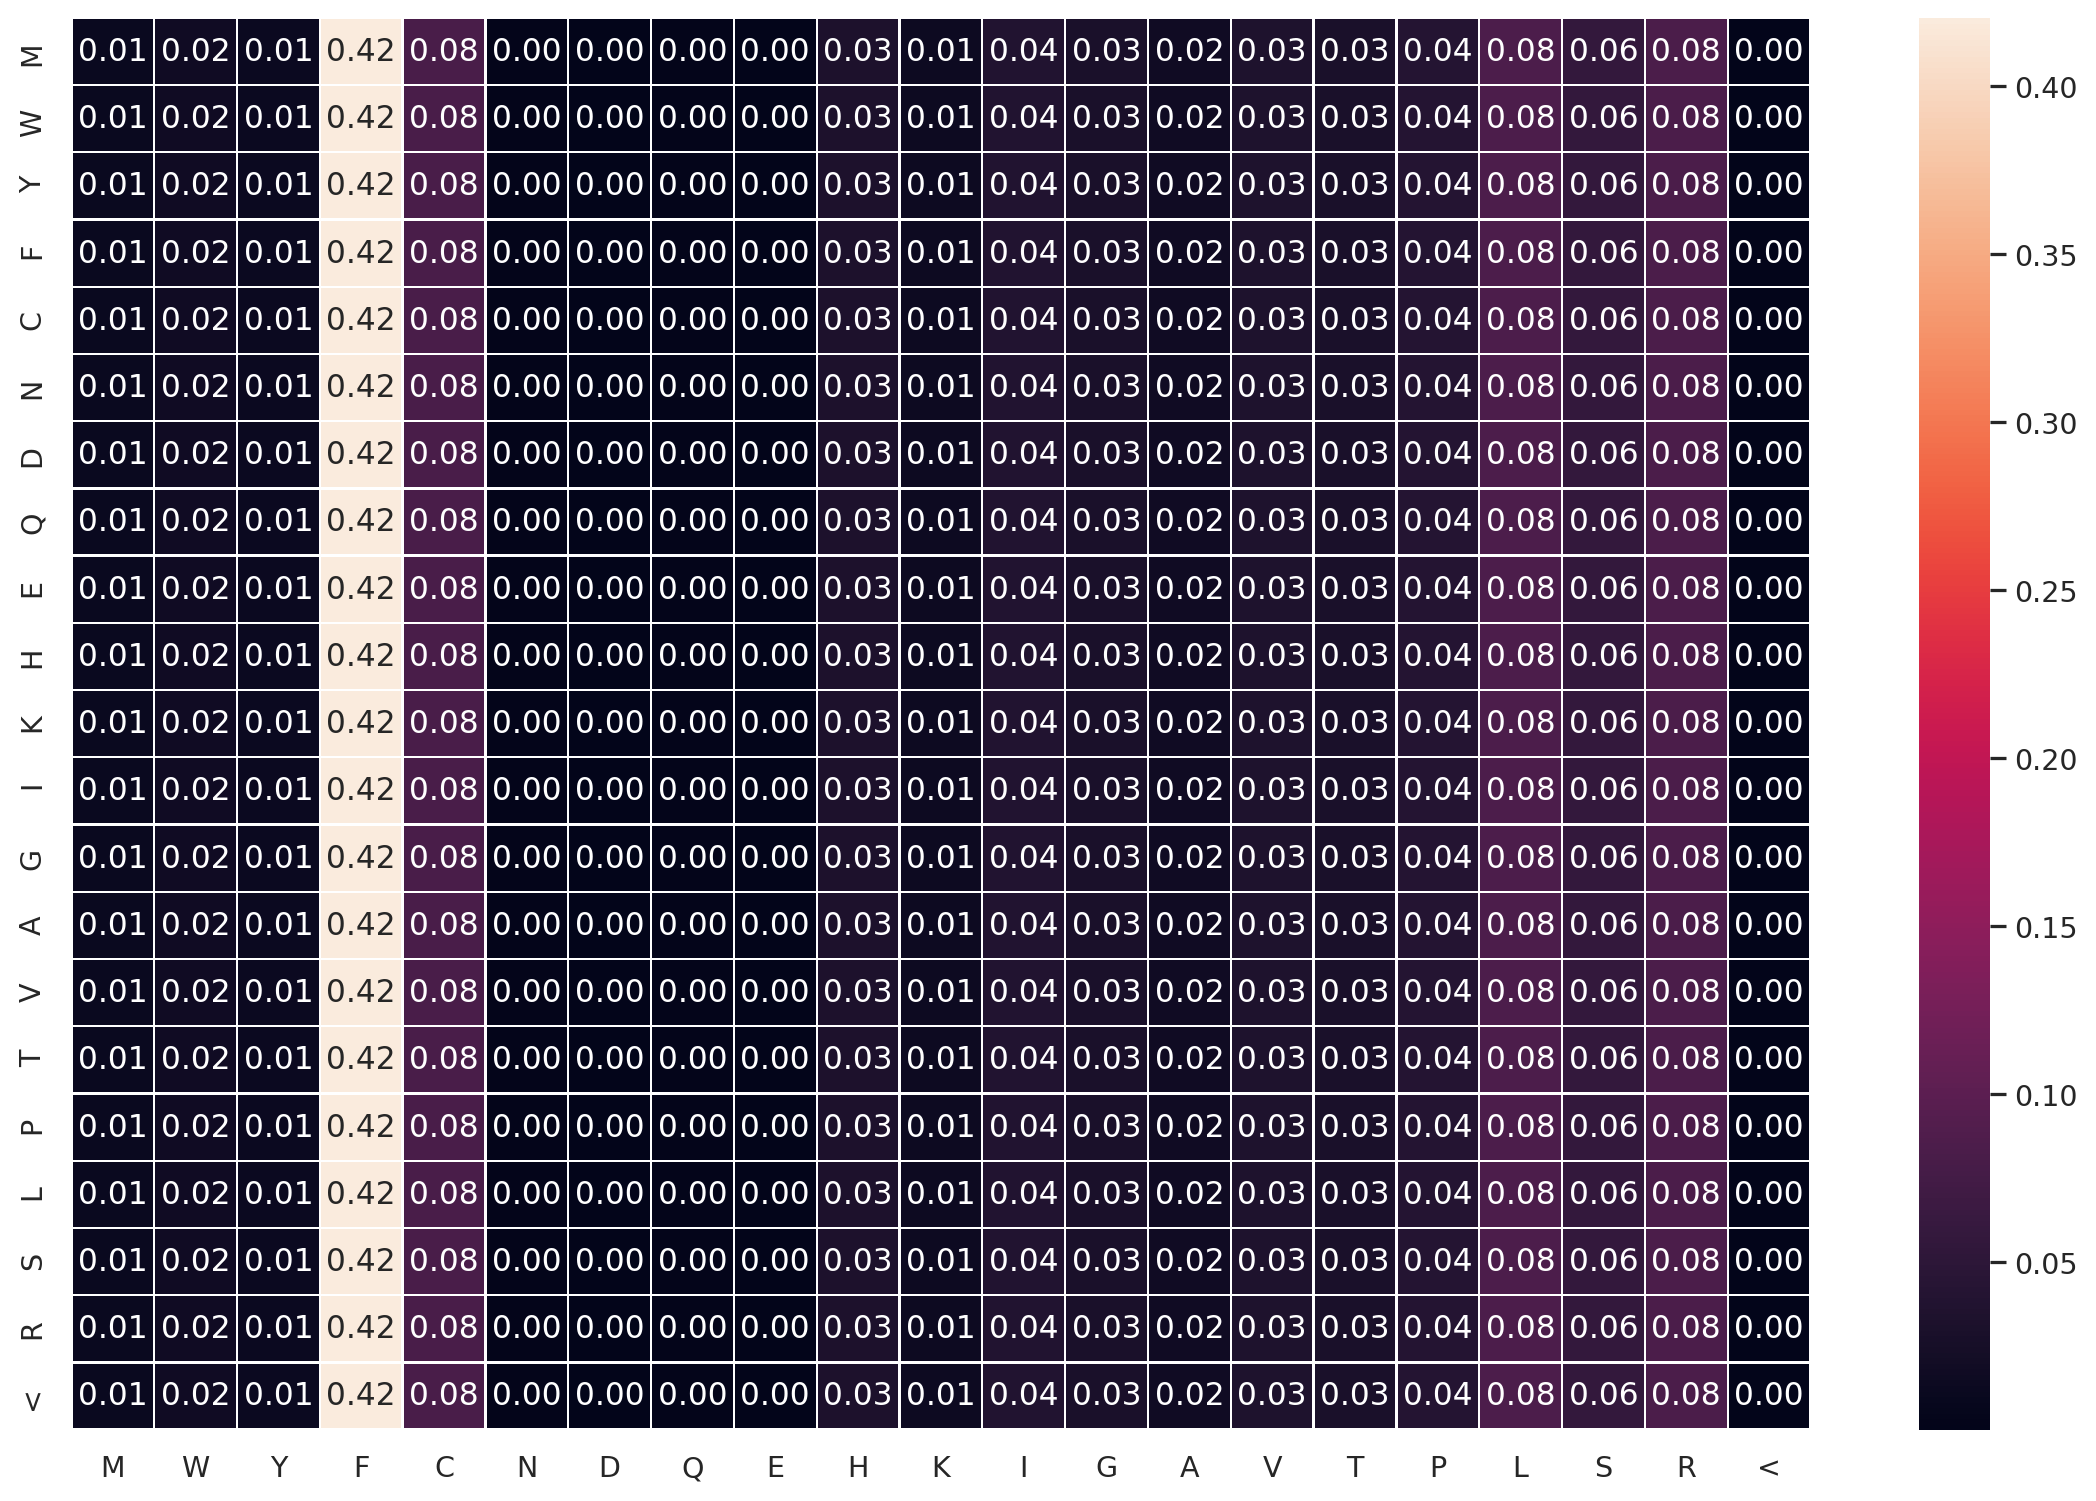

In [21]:
importlib.reload(vs)
tcmc = models['all_small'].get_layer("P_sequence_columns")
A = vs.amino_acid_probability_distribution(tcmc, t=100, model_id=0)
#print(A)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 10), dpi=187)
ax = sns.heatmap(A, annot=True, fmt=".2f", linewidths=.5, xticklabels=list(vs.amino_acids.keys()), yticklabels=list(vs.amino_acids.keys()), ax=ax)
#ax.figure.savefig('aa.svg')

# print('Sanity check for A matrix (col sums):')
# print(np.sum(A,axis=1))